In [2]:
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pandas as pd

In [25]:
config = 'repl9' # 'part9'

/tmp/ipykernel_218328/2119505555.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_cycle = plt.cm.get_cmap('tab20', len(ordered_nodes))


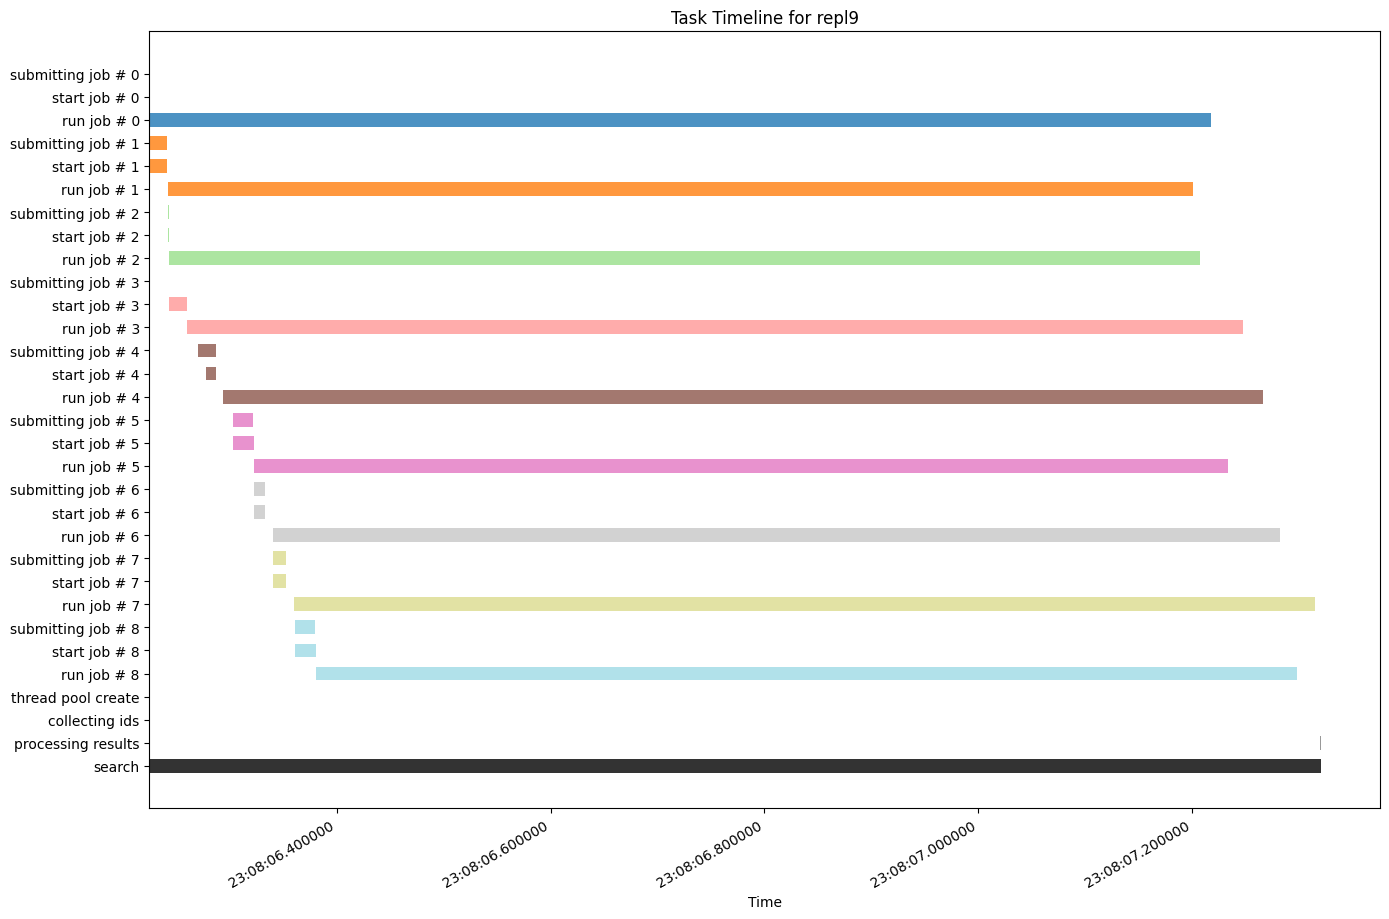

In [26]:
# Load the data
with open(f'{config}.json', 'r') as f:
    data = json.load(f)

# Parse all events
events = []
for entry in data:
    start = datetime.strptime(entry['start'], "%Y-%m-%d %H:%M:%S.%f")
    end = datetime.strptime(entry['end'], "%Y-%m-%d %H:%M:%S.%f")
    events.append({
        "label": entry['label'],
        "start": start,
        "end": end
    })

# Group by node for job events
job_types = ["submitting job", "start job", "run job"]
jobs = {}

other_events = []
search_event = None

for e in events:
    label = e['label']
    if label.startswith(tuple(job_types)):
        # Extract node
        if '#' in label:
            job_type, node = label.split('#', 1)
            job_type = job_type.strip()
            node = node.strip()
            if node not in jobs:
                jobs[node] = {}
            jobs[node][job_type] = e
    elif label == "search":
        search_event = e
    else:
        other_events.append(e)

# Order jobs by earliest event start time
ordered_nodes = sorted(
    jobs.items(),
    key=lambda item: min(ev["start"] for ev in item[1].values())
)

# Prepare colors for each node/port
color_cycle = plt.cm.get_cmap('tab20', len(ordered_nodes))
node_colors = {node: color_cycle(i) for i, (node, _) in enumerate(ordered_nodes)}

# Prepare y-ticks and plotting
y_labels = []
plot_events = []
y_pos = 0

for node, evdict in ordered_nodes:
    for job_type in job_types:
        if job_type in evdict:
            ev = evdict[job_type]
            y_labels.append(ev['label'])
            plot_events.append((y_pos, ev, node_colors[node]))
            y_pos += 1

# Add other events (except "search"), ordered by start time, use gray
other_events_sorted = sorted(other_events, key=lambda e: e['start'])
for ev in other_events_sorted:
    y_labels.append(ev['label'])
    plot_events.append((y_pos, ev, 'gray'))
    y_pos += 1

# Add "search" at the end, use black
if search_event:
    y_labels.append(search_event['label'])
    plot_events.append((y_pos, search_event, 'black'))

fig, ax = plt.subplots(figsize=(14, max(6, len(y_labels) * 0.3)))

for y, e, color in plot_events:
    ax.barh(
        y,
        e['end'] - e['start'],
        left=e['start'],
        height=0.6,
        align='center',
        color=color,
        alpha=0.8
    )

ax.set_yticks(range(len(y_labels)))
ax.set_yticklabels(y_labels)
ax.invert_yaxis()

ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S.%f'))
fig.autofmt_xdate()

plt.xlabel('Time')
plt.title(f'Task Timeline for {config}')

plt.tight_layout()
plt.show()

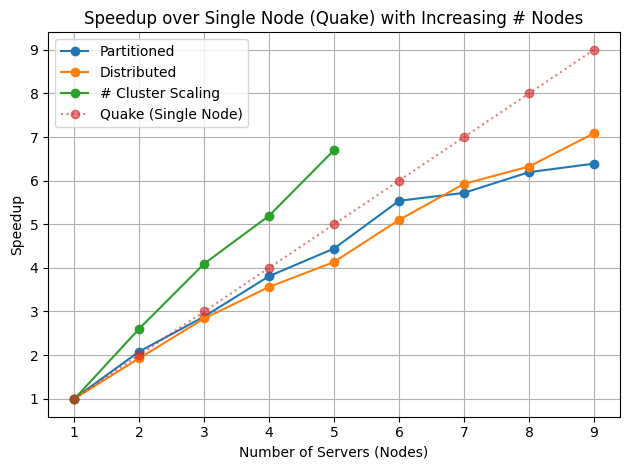

In [3]:
# Load the data
df = pd.read_csv('speedup_data.csv')

# Prepare the x-axis (number of servers/nodes)
x = df['Servers (Nodes)']

# Plot each speedup method
plt.plot(x, df['Partitioning'], marker='o', label='Partitioned')
plt.plot(x, df['Replication'], marker='o', label='Distributed')
plt.plot(x, df['# Cluster Scaling'], marker='o', label='# Cluster Scaling')
plt.plot(
    x, df['Quake (Single Node)'],
    marker='o',
    label='Quake (Single Node)',
    linestyle=':',
    alpha=0.6
)

plt.xlabel('Number of Servers (Nodes)')
plt.ylabel('Speedup')
plt.title('Speedup over Single Node (Quake) with Increasing # Nodes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()